<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/ian_testingground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook used to test project ideas
Author: Ian Byrne

Email: ianbyrne@umich.edu

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Reading in data stream

In [1]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 432, done.
remote: Counting objects: 100% (432/432), done.
remote: Compressing objects: 100% (360/360), done.
remote: Total 432 (delta 240), reused 160 (delta 66), pack-reused 0
Receiving objects: 100% (432/432), 3.23 MiB | 4.23 MiB/s, done.
Resolving deltas: 100% (240/240), done.
/content/MADSmilestone2
Data			 Images.ipynb  Labeling  README.md
ian_testingground.ipynb  Images.py     Loading	 Supervised_CNN.ipynb


Load imports as necessary

In [2]:
!pip install boto3 tqdm

     |████████████████████████████████| 131 kB 5.0 MB/s 
     |████████████████████████████████| 79 kB 5.7 MB/s 
     |████████████████████████████████| 7.9 MB 40.5 MB/s 
     |████████████████████████████████| 138 kB 51.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.6 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
from tqdm import tqdm

In [4]:
import Loading.load_data as loading

import io
import logging
import os
import ast
import boto3
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from botocore.exceptions import ClientError
import botocore
import tempfile

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


 Connect to S3 using the python client boto3
 - Access keys are loaded from clockss3 which is contained within my loacl google drive. 

In [8]:
# also import keys for aws connection
from gdrive.MyDrive.Colab_Notebooks.clocks_aws_config import clockss3
pubkey = clockss3['accessCode']
seckey = clockss3['secretCode']

In [9]:
client = boto3.client('s3', aws_access_key_id=pubkey, aws_secret_access_key=seckey)
response = client.list_buckets()
# response['Buckets']

In [10]:
s3 = boto3.resource('s3', aws_access_key_id=pubkey, aws_secret_access_key=seckey)
list(s3.buckets.all())

[s3.Bucket(name='aws-cloudtrail-logs-598991111123-85ddbc5c'),
 s3.Bucket(name='clockdrawingbattery'),
 s3.Bucket(name='clockdrawingimages'),
 s3.Bucket(name='clockdrawingimages1'),
 s3.Bucket(name='clockdrawingimages2'),
 s3.Bucket(name='clockdrawingimages3'),
 s3.Bucket(name='clockimages'),
 s3.Bucket(name='healthyhomes591'),
 s3.Bucket(name='test-bucket-clockids-aicrowd')]

In [11]:
bucket = s3.Bucket('clockimages')

In [ ]:
objs = list(bucket.objects.all())
objs[:5]

[s3.ObjectSummary(bucket_name='clockimages', key='NHATS_R10_ClockDrawings/10000008.tif'),
 s3.ObjectSummary(bucket_name='clockimages', key='NHATS_R10_ClockDrawings/10000019.tif'),
 s3.ObjectSummary(bucket_name='clockimages', key='NHATS_R10_ClockDrawings/10000021.tif'),
 s3.ObjectSummary(bucket_name='clockimages', key='NHATS_R10_ClockDrawings/10000022.tif'),
 s3.ObjectSummary(bucket_name='clockimages', key='NHATS_R10_ClockDrawings/10000036.tif')]

In [ ]:
def create_bucket(client, bucket_name, region=None):
    """Create an S3 bucket in a specified region

    If a region is not specified, the bucket is created in the S3 default
    region (us-east-1).

    :param bucket_name: Bucket to create
    :param region: String region to create bucket in, e.g., 'us-west-2'
    :return: True if bucket created, else False
    """

    # Create bucket
    try:
        if region is None:
            s3_client = client
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client = client
            location = {'LocationConstraint': region}
            s3_client.create_bucket(Bucket=bucket_name,
                                    CreateBucketConfiguration=location)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [ ]:
# # create test bucket:
# create_bucket(client, "test-bucket-clockids-aicrowd", region="us-west-1")

In [ ]:
#list(s3.buckets.all())

~~Import dataframe containing spid, description of clock, diagnosis, round~~

Import the text file containing the dictionary of rounds and their spids and lebels. 
- Transform into a nested list to make loops easier. 

In [ ]:
file = open("Data/roundIdLabelDict.txt", "r")

contents = file.read()
round_dict = ast.literal_eval(contents)

In [ ]:
round_dict[4][0]

('10001875', 0)

### Custom data set, idea:
- take in the dataframe from the rounds_df
- utiilize the spid number and the round number to call S3 dynamically and retrieve the correct URL for the .tif image
- tbd: any transforms to be done on the images to prepare for learning
    - Can likely ultilize this to loop through the large images and convert to smaller images and then save them to a new directory/ or locally to make the data more manageable 
- Should return the image in tensor format and the label (diagnosis)

In [ ]:
class ClockImages(Dataset):
    """Original large format clock drawing dataset"""

    def __init__(self, round, round_labels):
        """
        Args:
            round (int): Round to grab images from. 
            values (list of tuples): Corresponding values for the round.
        """
        self.round = round
        self.vals = round_labels
        self.client = boto3.client('s3', 
                                   aws_access_key_id=pubkey, 
                                   aws_secret_access_key=seckey)


    def __len__(self):
        return len(self.vals)

    
    def __getitem__(self, idx):
        spid = self.vals[idx][0]
        label = self.vals[idx][1]
        bucket = "clockimages"                                                          # f"clockdrawingimages{self.round}"
        obj_name = f"NHATS_R{self.round}_ClockDrawings/{spid}.tif"
        #print(obj_name)                     # f"{spid}.tif"
        filename = str(spid)+".tif"
        #print(filename)

        client.download_file(bucket, obj_name, filename)

        im = Image.open(filename)
        resized = im.resize((160, 207)) 
        im_arr = np.array(resized)

        
        sample = {'image': im_arr, 'name': str(self.round)+"_"+filename}

        return sample



In [ ]:
# modified from S3 boto3 documentation: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-uploading-files.html
def s3_upload(data, bucket, obj):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # Upload the file
    s3_client = client
    try:
        # response = client.put_object( 
        #                             Bucket=bucket,
        #                             Body=data,
        #                             Key=obj
        #                             )
        response = s3_client.upload_file(data, bucket, obj)
        #print("upload complete")
    except ClientError as e:
        logging.error(e)
        return False
    return True


In [ ]:
def to_byte_body(x):
    buff = io.BytesIO()
    torch.save(x, buff)
    #byte_body = buff.seek(0)
    return buff

In [ ]:
data = ClockImages(10, round_dict[10])
clock_dataloader = DataLoader(dataset=data)
for sample in tqdm(clock_dataloader):

    # convert from tensor to array
    im_arr = np.asarray(sample['image'][0])

    # convert back to image
    im = Image.fromarray(im_arr)

    # save image locally to upload
    im.save("im2upload.tif", "TIFF")
    s3_upload("im2upload.tif", 'test-bucket-clockids-aicrowd', sample["name"][0])

  0%|          | 6/3797 [00:03<33:43,  1.87it/s]


ClientError: ignored

In [ ]:
# # quick value checks
print(data.round)
# print(data.vals)
print(data.vals[0][0])
print(data.vals[0][1])

# # should be equivalent to obj_name
print("\n",type(f"{data.vals[0][0]}.tif"))
print(f"{data.vals[0][0]}.tif")

8
10000003
1

 <class 'str'>
10000003.tif


In [ ]:
"""class ResizedClocks(Dataset):
    Resized clock drawing dataset

    def __init__(self, round, round_labels):
        
        #Args:
            #round (int): Round to grab images from. 
            #values (list of tuples): Corresponding values for the round.
        
        self.round = round
        self.vals = round_labels
        self.client = boto3.client('s3', 
                                    aws_access_key_id=pubkey, 
                                    aws_secret_access_key=seckey)
    
    def __len__(self):
        return len(self.vals)

    def __getitem__(self, idx):
        spid = self.vals[idx][0]
        label = self.vals[idx][1]
        bucket = "test-bucket-clockids-aicrowd"
        obj_name = f"{self.round}_{spid}.tif"
        
        client.download_file(bucket, obj_name, obj_name)

        im = Image.open(obj_name)
        im = np.array(im)

        sample = {'image': im, 'label': label}

        return sample"""

## Resizing images, convert any RGB images to grayscale, setting to binary, and saving into Train, Validate and Test image and label numpy array files

In [20]:
class ResizedClocks(Dataset):
    #Resized clock drawing dataset

    def __init__(self, round, round_labels):
        
       # Args:
           # round (int): Round to grab images from. 
           # values (list of tuples): Corresponding values for the round.
        
        self.round = round
        self.vals = round_labels
        self.client = boto3.client('s3', 
                                    aws_access_key_id=pubkey, 
                                    aws_secret_access_key=seckey)
    
    def __len__(self):
        return len(self.vals)

    def __getitem__(self, idx):
        spid = self.vals[idx][0]
        label = self.vals[idx][1]
        bucket = "clockimages" #"test-bucket-clockids-aicrowd"
        obj_name = f"NHATS_R{self.round}_ClockDrawings/{spid}.tif" #f"{self.round}_{spid}.tif"
        #filename = str(spid)+".tif"
        temp = tempfile.NamedTemporaryFile()

        try:
          client.download_file(bucket, obj_name, temp.name)

          im = Image.open(temp.name)

          gray = im.convert('1')
          resized = gray.resize((160, 207)) 
          im_arr = np.array(resized).astype(int)

          sample = {'image': im_arr, 'label': label}
        
          temp.close()

          return sample
          
        except botocore.exceptions.ClientError as e:
          #logging.error(e)
          return





"""Load the dictionary with IDs, rounds and labels
# train_dict.txt
# test_dict.txt
# val_dict.txt"""
customDict_file = open("Data/train_dict.txt", "r")
#print(customDict_file.readline())
contents = customDict_file.read()
dictionary = ast.literal_eval(contents)
customDict_file.close()





"""Create arrays to store the data and labels
Create separate files for train, val, test
by passing in only the corresponding dictionary """
image_array = []
label_array = []
round_val = [1,2,3,4,5,6,7,8]#,9,10]

for val in round_val:
  data = ResizedClocks(val, dictionary[val])
  for sample in tqdm(data):
    try:
      image_array.append(sample['image'])
      label_array.append(sample['label'])
    except TypeError as e:
      #logging.error(e)
      pass 

np.save('train_images{}.npy'.format(val), image_array) # save images
np.save('train_labels{}.npy'.format(val), label_array) # save labels

100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Label:  0
Shape:  (207, 160)
Length:  1
Image: 


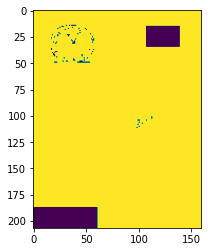

In [23]:
plt.imshow(image_array[0])
print("Label: ", label_array[0])
print("Shape: ", image_array[0].shape)

print("Length: ", len(image_array))
print("Image: ")

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

tensor([1])
tensor([[[[255, 255, 255, 255],
          [255, 255, 255, 255],
          [255, 255, 255, 255],
          ...,
          [255, 255, 255, 255],
          [255, 255, 255, 255],
          [255, 255, 255, 255]],

         [[255, 255, 255, 255],
          [255, 255, 255, 255],
          [255, 255, 255, 255],
          ...,
          [255, 255, 255, 255],
          [255, 255, 255, 255],
          [255, 255, 255, 255]],

         [[255, 255, 255, 255],
          [255, 255, 255, 255],
          [255, 255, 255, 255],
          ...,
          [255, 255, 255, 255],
          [255, 255, 255, 255],
          [255, 255, 255, 255]],

         ...,

         [[255, 255, 255, 255],
          [255, 255, 255, 255],
          [255, 255, 255, 255],
          ...,
          [255, 255, 255, 255],
          [255, 255, 255, 255],
          [255, 255, 255, 255]],

         [[255, 255, 255, 255],
          [255, 255, 255, 255],
          [255, 255, 255, 255],
          ...,
          [255, 255, 255, 

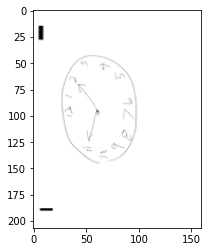

In [ ]:
data = ResizedClocks(8, round_dict[8][:1])
resize_dataloader = DataLoader(dataset=data)
for sample in tqdm(resize_dataloader):
    print(sample["label"]) 
    print(sample['image'])
    plt.imshow(np.asarray(sample["image"][0]))

In [ ]:
# clean up local files
!rm *.tif